In [1]:
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import h5py
import matplotlib.pyplot as plt
import bilby

import lwp
import lwp.utils.io as io

from lwp import executables

# Set to true the first time this is run, 
# can be turned off later to save time/bandwidth
download_astro_samples = False
download_eos_samples = False

In [2]:
# Download Astrophysical samples and compute the bandwidth for the samples.
# We also get the chirp-mass range and mass-ratio range of the samples, so we can 
# make sure the prior we set is not smaller than the support of the likelihood.
# You can specify a "load_function" which helps the code translate the input format
# given to the common lwp table-column format.  This must be done for public h5 samples
# because of the degeneracy with bilby-format .h5 result files. See `lwp/utils/io.py` 
# for a list of possible load functions. 
# This will also save the samples and .in file by default.
if download_astro_samples:
    astro_data_and_metadata = executables.get_files.get_astro_samples(
    "IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5", 
    "PE190425_low_spin.csv", 
    download_url="https://zenodo.org/record/6513631/files/IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5?download=1,",
    max_num_pe_samples=1500,
    load_samples_kwargs = {"load_function": io.load_public_h5_samples, "low_spin":True})
    
    # Get the data we need to run lwp_pipe
    astro_prefix= "PE190425_low_spin"
    astro_data = astro_data_and_metadata["data"]
    bandwidth = astro_data_and_metadata["bandwidth"]
    chirp_mass_range = np.array(astro_data_and_metadata["mc_range"].iloc[0,:])

In [3]:
# See all of the options for get_astro_samples
?executables.get_files.get_astro_samples

Signature:
executables.get_files.get_astro_samples(
    specific_file_name,
    dataframe_outpath,
    download_url=None,
    max_num_pe_samples=None,
    load_samples_kwargs={},
    scan_likelihood=True,
    scan_likelihood_kwargs={'cols': ['m1', 'm2', 'Lambda1', 'Lambda2', 'luminosity_distance_Mpc']},
    verbose=True,
)
Docstring:
Take a raw astrophysical posterior from GW PE and return the data
needed for lwp_pipe, including the data in a dataframe and the optimal
bandwidth for the likelihood kde.  Also return the range of chirp mass and 
mass ratio samples.  

Inputs:
specific_file_name : str
  The path to a file that holds posterior samples, should have a format which
  can be read by the utils.io loading utilities.  
dataframe_outpath : str 
  Path to save the resulting lwp-style dataframe to as a csv.
download_url : str
  If not None, download this file which contains the astro samples
  Unzip the file if it is compressed
max_num_pe_samples : int
  If not None, downsample the P

In [4]:
# If the samples are already on disk, no need to download them again,
# we can just read the bandwidth out of the saved file
# (If the samples are already on disk but the .in file doesn't exist, no worries! just 
# call the function above `get_astro_samples` with `download_url` set to `None`, and no 
# extra downloading will be done.)
astro_prefix= "PE190425_low_spin"
if not(download_astro_samples):
    astro_data_and_metadata = executables.get_files.get_astro_samples(
    "PE190425_low_spin.csv", 
    "PE190425_low_spin.csv", 
    download_url=None, # No download neede 
    max_num_pe_samples=1500, # We'll probably already have this many samples
    scan_likelihood=False, # Assume the .in file is stored
    load_samples_kwargs = {}) # The correct loading function will be called on already-processed .csv's
    
    # Get the data we need to run lwp_pipe
    
    astro_data = astro_data_and_metadata["data"]
    bandwidth = astro_data_and_metadata["bandwidth"]
    chirp_mass_range = np.array(astro_data_and_metadata["mc_range"].iloc[0,:])

successfully got 1500 pe samples,
downsampling to 1500 samples


In [5]:
# Download an example set of EoSs to be used by the LVK in O4
if download_eos_samples:
    samples_url = "https://zenodo.org/record/6502467/files/LCEHL_EOS_posterior_samples_PSR.h5?download=1"
    samples_file =  "LCEHL_EOS_posterior_samples_PSR.h5"
    !curl {samples_url} -o {samples_file}


In [6]:
# This code defines the needed map from eos-indices to macroscopic m-lambda
# relations.  It also defines which EoS to be used by specifying which integers
# `eos_to_be_used` should be used as keys to the `macro_data` mapping
# For a better resolved run, simply use more EoSs e.g. `eos_to_be_used = np.arange(10000)`.
# You can also use your own EoS set by just creating a `macro_data`
# which maps integers to your M-Lambda curves 
# e.g. macro_data = {eos_num : pd.read_csv(f"my_m_lambda_curve_{eos_num}.csv")}
# just make sure the columns  "M", "Lambda" appear.  
samples_file =  "LCEHL_EOS_posterior_samples_PSR.h5"
samples_tag = "np"
samples  = h5py.File(samples_file)
ex_ns = np.array(samples['ns']['eos_0'])

eos_to_be_used = np.array(samples['id'])
eos_to_be_used=np.arange(10)
macro_data = {eos_num: np.array(samples['ns'][eos_id]) for eos_num, eos_id in enumerate(samples['eos'])}

In [7]:
# Dump the config ("ini") file needed to run lwp-pipe bin script.
# This will produce a file "example_nb.ini".  This call to `lwp_pipe`
# is essentially stored in this file.  Just call `bin/lwp-pipe example_nb.ini`
# and the call will execute.  The .ini file can also be modified to, for example,
# run on condor, see the example ini file `./example.ini` to see how to specify condor arguments.
# Running on condor can be used to significantly improve runtimes with large numbers of EoSs.
result = executables.lwp_pipe(eos_indices = np.array(eos_to_be_used),
                    retrieve_macro_data = lambda index: macro_data[index], 
                    gw_posterior_samples = astro_data,
                    likelihood_bandwidth=bandwidth, 
                    save_likelihoods=f"./{astro_prefix}_post.csv",
                    save_marginalized_likelihoods=f"./{astro_prefix}_eos.csv",
                    mc_marginalization_range=chirp_mass_range,
                    seed=12345,
                    dump_config="example_nb.ini", 
                    dump_config_kwargs={"config_kwargs": {"eos-indices": "eos_indices.csv"}, 
                                        "lwp_pipe_data_kwargs":{"gw_posterior_samples": "PE190425_low_spin.csv",
                                                                "eos_samples_h5_path":samples_file, 
                                                                "eos_samples_h5_macro_subgroup":"ns",
                                                                "outdir":"DefaultOutdir"}})

In [8]:
# Actually compute the likelihoods and marginal likelihoods.
# This is the primary executable of lwp, it computes the likelihoods
# of each EoS 
result = executables.lwp_pipe(
    eos_indices = np.array(eos_to_be_used),
    retrieve_macro_data = lambda index: macro_data[index], 
    gw_posterior_samples = astro_data,
    likelihood_bandwidth=bandwidth, 
    mc_marginalization_range=chirp_mass_range,
    save_likelihoods=f"./{astro_prefix}_post.csv",
    save_marginalized_likelihoods=f"./{astro_prefix}_eos.csv")

In [9]:
# This is, for example, all of the likelihood evaluations L(m1, m2, Lambda(m1, EoS), Lambda(m2, EoS), EoS)
likelihoods= result["likelihood_evaluations"]


In [10]:
# see all the available arguments
?executables.lwp_pipe

Signature:
executables.lwp_pipe(
    eos_indices,
    retrieve_macro_data,
    gw_posterior_samples,
    astro_columns=None,
    prior_columns=['m1', 'm2', 'Lambda1', 'Lambda2', 'luminosity_distance_Mpc'],
    max_num_pe_samples=None,
    marginalization_mass_prior=None,
    save_likelihoods=None,
    save_marginalized_likelihoods=None,
    load_samples_kwargs={},
    num_proc=15,
    num_marginalization_points=50,
    mc_marginalization_range=(0.8, 1.6),
    q_marginalization_range=(0.2, 1.0),
    likelihood_bandwidth=0.03,
    likelihood_prior_key='flat_m1m2det',
    seed=None,
    dump_config=None,
    dump_config_kwargs={},
    verbose=False,
)
Docstring:
Weigh each equation of state represented in eos_indices by 
the data represented in gw_posterior samples by monte carlo
sampling the distribution marginalization_mass_prior.  

Requires : 
  eos_indices: a numerical list of eos_indices to use,
    must be unique integer identifier of eos
  retrieve_macro_data: a function which tak

(array([178., 155., 193., 139., 178.,  87., 219., 169., 203., 114.,  51.,
        283., 228.,  93., 267., 254., 123.,  69., 116.,  80., 142., 133.,
         45.,   0., 114., 113.,   0.,   1.,  12.,  45.,  40.,   4.,  15.,
          0.,  43.,   1.,   4.,   0.,   0.,   0.,   1.,   0.,   6.,   0.,
         27.,   0.,   6.,  12.,   0.,   0.,   0.,   4.,   0.,  30.,   0.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.]),
 array([  68.2386895 ,   90.2799238 ,  112.3211581 ,  134.3623924 ,
         156.40362669,  178.44486099,  200.48609529,  222.52732959,
         244.56856389,  266.60979819,  288.65103249,  310.69226679,
         332.73350109,  354.77473538,  376.81596968,  398.85720398,
         420.89843828,  442.93967258,  464.98090688,  487.02214118,
         509.06337548,  531.10460978,  553.14584407,  575.18707837,
         597.22831267,  619.26954697,  641.31078127,  663.35201557,
         685.39324987,  707.43448417,  729.475

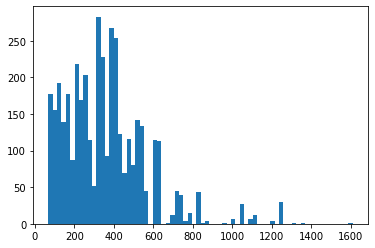

In [11]:
# Check to see inferred Lambda values are sane
plt.hist(np.random.choice(
    likelihoods["Lambda2"], size=4000, 
    p=np.exp(likelihoods["logweight"])/np.sum(np.exp(likelihoods["logweight"]))),
    bins=70)

In [12]:
# The result dictionary stores the results and marginalization parameters
result.keys()

dict_keys(['likelihood_evaluations', 'eos_likelihoods', 'prior'])